# Testings for PlesioGeostroPy

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from scipy import special as specfun
import matplotlib.pyplot as plt

from pg_utils.pg_model import base, core

import os, perfplot
plt.style.use("default")

**Regularity tests** are now removed from this notebook.
For further regularity conditions and tests, see [Demo_Regularity.ipynb](Demo_Regularity.ipynb)

---
## Jacobi polynomial evaluation

In [2]:
from scipy.special import eval_jacobi, roots_jacobi
from pg_utils.numerics.special import eval_jacobi_recur, eval_jacobi_nrange, eval_jacobi_recur_Nmax

### Precision test

In [15]:
n_range = np.arange(-2, 101)
alpha, beta = 1/2, -1/2
xi, wt = roots_jacobi(101, alpha, beta)
N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [16]:
Jacobi_val_scipy = eval_jacobi(N_mesh, alpha, beta, X_mesh)
Jacobi_val_recur = eval_jacobi_recur(N_mesh, alpha, beta, X_mesh)

Compare the results

C:\Users\gentle\AppData\Local\Temp\ipykernel_17356\3781117974.py:6: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(X_mesh, N_mesh, np.clip(np.log10(relative_err), *cmap_range))


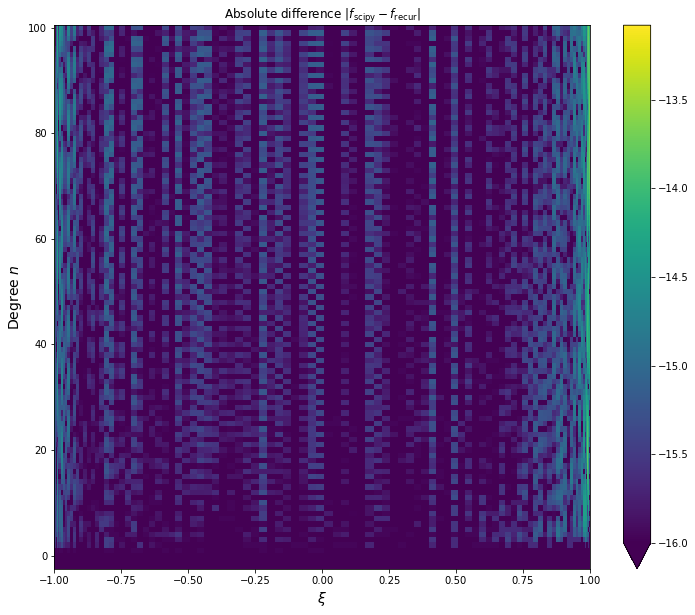

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))

cmap_range = [-16, None]

relative_err = np.abs(Jacobi_val_scipy - Jacobi_val_recur)
im = ax.pcolormesh(X_mesh, N_mesh, np.clip(np.log10(relative_err), *cmap_range))
ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel("Degree $n$", fontsize=14)
ax.set_title(r"Absolute difference $|f_{\mathrm{scipy}} - f_{\mathrm{recur}}|$")
plt.colorbar(im, extend="min")

plt.show()

$L_2$-error

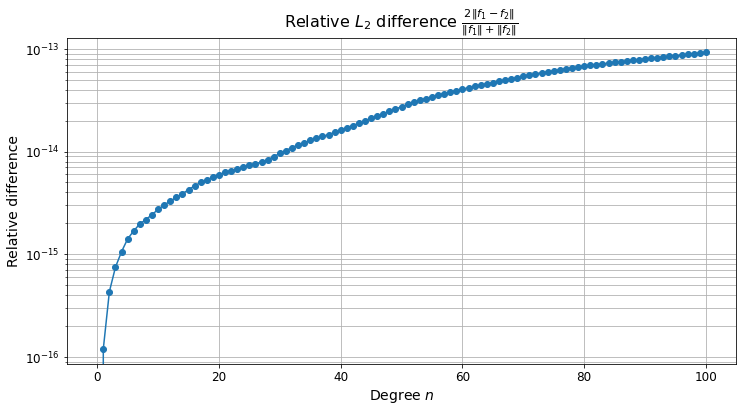

In [18]:
norm_Jacobi_scipy = np.sum(Jacobi_val_scipy**2*wt, axis=-1)
norm_Jacobi_recur = np.sum(Jacobi_val_recur**2*wt, axis=-1)
norm_diff = np.sum((Jacobi_val_scipy - Jacobi_val_recur)**2*wt, axis=-1)

fig, ax = plt.subplots(figsize=(12, 6))

relative_err = np.sqrt(norm_diff[n_range >= 0])/((np.sqrt(norm_Jacobi_recur[n_range >= 0]) + np.sqrt(norm_Jacobi_scipy[n_range >= 0]))/2)
ax.semilogy(n_range[n_range >= 0], relative_err, 'o-')
ax.set_xlabel("Degree $n$", fontsize=14)
ax.set_ylabel("Relative difference", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title(r"Relative $L_2$ difference $\frac{2\Vert f_1 - f_2 \Vert}{\Vert f_1\Vert + \Vert f_2\Vert}$", fontsize=16)
ax.grid(which="both")

plt.show()

It therefore seems that what is computed using recurrence relation and what is computed using the library function is different by at most $10^{-13}$, both in the absolute sense and in the relative sense.

It is also important to understand that `scipy.special.eval_jacobi` is not precise up to the last digit of machine precision! The following example shows you can easily find $10^{-14}$ absolute error near the edge of the interval.

In [19]:
print(eval_jacobi(50, 0.5, -0.5, -0.99988))

import mpmath as mp
with mp.workprec(112):
    print(mp.jacobi(50, 0.5, -0.5, -0.99988))

0.056451040336358276
0.0564510403363336568288337047684404


Therefore, the fact that recurrence relation implementation differs from the `scipy.special.eval_jacobi` calculation does not mean that the former is more erroneous. With multi-precision calculation below, one can actually show that the two have similar error level.

### Efficiency test

Define functions for testing

In [20]:
npts_eval = 100

def params_setup(Nmax):
    n_range = np.arange(Nmax + 1)
    alpha, beta = 1/2, -1/2
    xi, _ = roots_jacobi(npts_eval, alpha, beta)
    N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')
    return n_range, xi, N_mesh, X_mesh, alpha, beta

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [25]:
benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi(N_mesh, alpha, beta, X_mesh),
        lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_recur(N_mesh, alpha, beta, X_mesh)
        # lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_nrange(n_range[0], n_range[-1], alpha, beta, xi)
        # lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_to_Nmax(n_range[-1], alpha, beta, xi)
    ],
    labels=["scipy", "recurrence"],
    n_range=[int(10**(N/5)) for N in range(0, 16)],
    show_progress=False
)

Output()

Compare the results

In [26]:
benchmarks

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ scipy                  ┃ recurrence             ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1    │ 2.4000000000000003e-06 │ 2.7300000000000003e-05 │
│ 1    │ 2.4000000000000003e-06 │ 2.71e-05               │
│ 2    │ 4.2000000000000004e-06 │ 6.63e-05               │
│ 3    │ 7.6e-06                │ 7.43e-05               │
│ 6    │ 1.77e-05               │ 8.960000000000001e-05  │
│ 10   │ 4.1500000000000006e-05 │ 0.00010960000000000001 │
│ 15   │ 8.55e-05               │ 0.0001327              │
│ 25   │ 0.00024170000000000002 │ 0.0001818              │
│ 39   │ 0.0006177              │ 0.0002474              │
│ 63   │ 0.0015596000000000002  │ 0.00035850000000000004 │
│ 100  │ 0.0036339000000000002  │ 0.0005327              │
│ 158  │ 0.008407300000000001   │ 0.0008031000000000001  │
│ 251  │ 0.01949                │ 0.0012394              │
│ 398  │ 0.0466883              │ 0.0019453              │
│ 630  │ 0.1138726              │ 0.0030329000000000003  │
│ 1000 │ 0.28255650000000004    │ 0.0054135              │
└──────┴────────────────────────┴────────────────────────┘

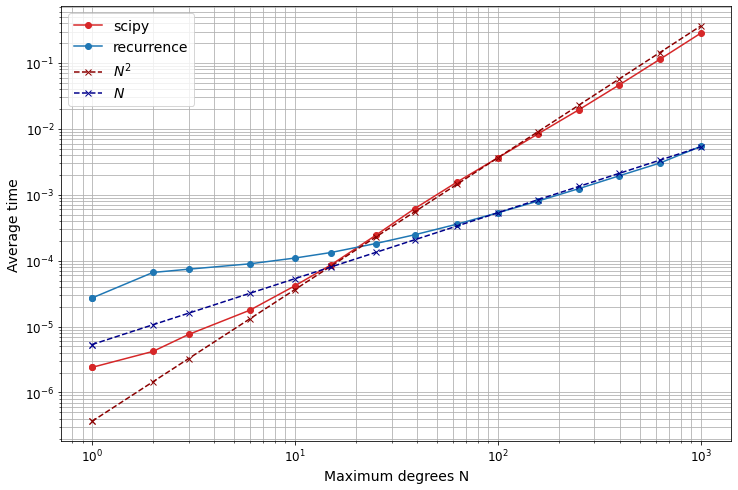

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

Scalings for two approaches
- Naively calling `scipy.special.eval_jacobi` on an array of degrees up to degree N gives a complexity of $O(N^2)$.
- Using recurrence relations to generate values for the same array of degrees gives a complexity of $O(N)$.

Naturally, `scipy` functions are better optimized and this particular function is computed with C functions.
A factor of $\sim 10$ exists between the two implementations at low degrees, and the current crossing point of the two complexity curves is located at $N\approx 20$.

Profiler

In [33]:
%lprun -f eval_jacobi_recur_Nmax [eval_jacobi_nrange(0, 100, alpha, beta, xi) for i in range(500)]

Timer unit: 1e-07 s

Total time: 0.337433 s
File: C:\Users\gentle\Documents\Projects\PG-Assim\pg_utils\numerics\special.py
Function: eval_jacobi_recur_Nmax at line 229

Line #      Hits         Time  Per Hit   % Time  Line Contents
   229                                           def eval_jacobi_recur_Nmax(Nmax: int, alpha: float, beta: float, 
   230                                               z: np.ndarray) -> np.ndarray:
   231                                               """Evaluate Jacobi polynomials with recurrence relation up to a degree
   232                                               
   233                                               This functions generates values for Jacobi polynomials from degree 0
   234                                               up to a specified degree, using recurrence relations.
   235                                               
   236                                               :param int Nmax: maximum degree, required to be >= 1
   

---
## Inner product calculation

In [34]:
from pg_utils.numerics import matrices
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import expand_conjugate as xpd_cfg
from eigen_solve import routine_matrix_calculation

### Single inner product efficiency

In [35]:
import json
from pg_utils.pg_model import params
from sympy import oo, Integer, Rational

matrix_expr_file = "./out/eigen/Malkus/Transformed/matrix_expr.json"
matrix_name = 'M'
element_name = ("Psi", "Psi")

PHYS_PARAMS = {
    xpd.m: Integer(3), 
    params.Le: Rational(1, 10000), 
    params.Lu: oo
}

with open(matrix_expr_file, 'r') as fread:
    matrix_obj = json.load(fread)
M_expr = xpd.SystemMatrix.deserialize(matrix_obj[matrix_name])
ip_element = M_expr[element_name].subs(PHYS_PARAMS)
ip_quad = matrices.InnerQuad_GaussJacobi(ip_element, automatic=True, quadN=None)

In [36]:
Ntrunc = 5
nrange = np.arange(Ntrunc + 1)

ip_eval = ip_quad.gramian(nrange, nrange, backend="scipy", output="numpy", outer=False, verbose=True)

Integrating with alpha=3/2, beta=3, N=6


Benchmarks between integration approach and outer product approach

In [37]:
def params_setup(Nmax):
    return matrix_expr_file, np.arange(Nmax + 1), xpd_cfg.recipe

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda fname, nrange, recipe: ip_quad.gramian(nrange, nrange, backend="scipy", output="numpy", outer=False, verbose=False),
        lambda fname, nrange, recipe: ip_quad.gramian(nrange, nrange, backend="scipy", output="numpy", outer=True, verbose=False),
    ],
    labels=["integrand", "outer product"],
    n_range=[int(N) for N in np.logspace(1, 2, num=10)],
    show_progress=False,
)

Output()

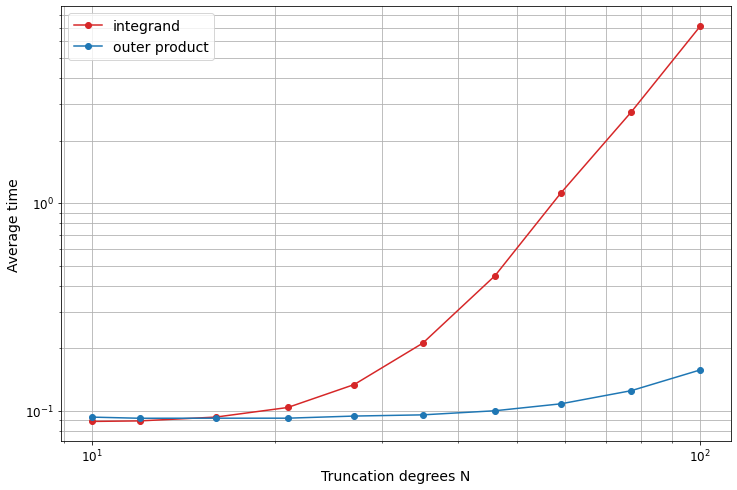

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Truncation degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

### Integrating entire matrices

In [39]:
matrix_expr_file = "./out/eigen/Malkus/Transformed/matrix_expr.json"
Ntrunc = 5

%time M_val, K_val = routine_matrix_calculation(read_from=matrix_expr_file, Ntrunc=Ntrunc, xpd_recipe=xpd_cfg.recipe, save_to=None, outer=False, verbose=0)

CPU times: total: 1.95 s
Wall time: 2.18 s


In [41]:
def params_setup(Nmax):
    return matrix_expr_file, Nmax, xpd_cfg.recipe

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda fname, Ntrunc, recipe: routine_matrix_calculation(read_from=fname, Ntrunc=Ntrunc, xpd_recipe=recipe, save_to=None, outer=False, verbose=0),
        lambda fname, Ntrunc, recipe: routine_matrix_calculation(read_from=fname, Ntrunc=Ntrunc, xpd_recipe=recipe, save_to=None, outer=True, verbose=0),
        # lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_to_Nmax(n_range[-1], alpha, beta, xi)
    ],
    labels=["integrand", "outer product"],
    n_range=[N for N in range(5, 51, 5)],
    equality_check=lambda x, y: np.allclose(x, y, rtol=1e-12, atol=1e-12),
    show_progress=False
)

Output()

Compare the results

In [42]:
benchmarks

┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ n  ┃ integrand          ┃ outer product      ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 5  │ 1.652646           │ 1.7342855000000001 │
│ 10 │ 1.6284591000000002 │ 1.8409247000000002 │
│ 15 │ 1.7544601000000002 │ 1.7317008          │
│ 20 │ 2.009061           │ 1.7326515          │
│ 25 │ 2.7371796          │ 1.7503939000000002 │
│ 30 │ 3.6698987          │ 1.8049171000000002 │
│ 35 │ 5.5097454          │ 1.9230028000000001 │
│ 40 │ 8.0336697          │ 1.8559846000000002 │
│ 45 │ 11.716146100000001 │ 2.0080449000000002 │
│ 50 │ 16.590471100000002 │ 1.9768878          │
└────┴────────────────────┴────────────────────┘

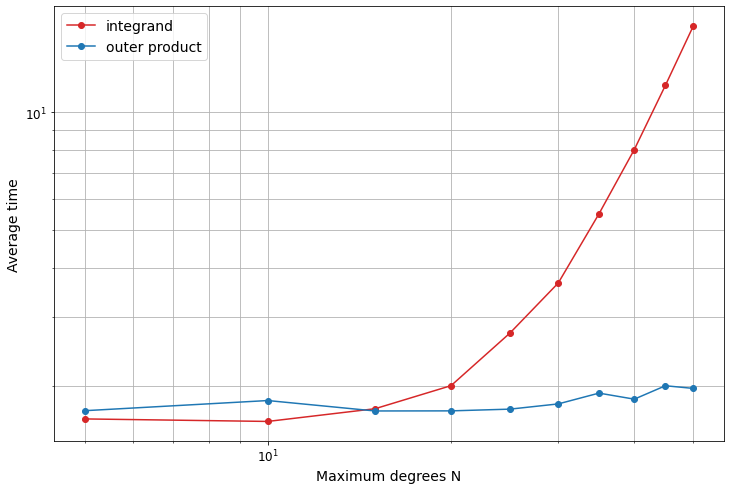

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

---
## Multi-precision libraries

The two multi-precision (arbitrary precision) libraries that can be relatively easily manipulated in Python are `mpmath` (**M**ulti-**P**recision **Math**ematics, a pure Python library) and `gmpy2` (a C-coded Python extension module, probably obtained its name as it originally only supports the **G**NU **M**ulti-**P**recision arithmetic lib).

This section provides a comparison on the efficiency of the two modules.

### Data conversion efficiency

According to the benchmarks below, converting numpy array to gmpy2 floats is more efficient by a factor of 1.4 to over 2.

In [71]:
import gmpy2 as gp
import mpmath as mp
from pg_utils.numerics.special import to_gpmy2_f, to_mpmath_f

mp.mp.prec = 112
print(mp.mp)

ctx = gp.get_context()
ctx.precision = 112
print("gmpy2 context:\n  prec = {:d}".format(gp.get_context().precision))

Mpmath settings:
  mp.prec = 112               [default: 53]
  mp.dps = 33                 [default: 15]
  mp.trap_complex = False     [default: False]
gmpy2 context:
  prec = 112


In [89]:
rng = np.random.default_rng()

to_gp = np.vectorize(lambda x: gp.mpfr(x, 112), otypes=(object,))
to_mp = np.vectorize(lambda x: mp.mpf(x), otypes=(object,))

def params_setup(Nmax):
    return rng.normal(size=(Nmax, Nmax)), rng.normal(size=(Nmax, Nmax))

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda a, b: (to_gp(a), to_gp(b)),
        lambda a, b: (to_gpmy2_f(a, prec=112), to_gpmy2_f(b, prec=112)),
        lambda a, b: (to_mp(a), to_mp(b)),
        lambda a, b: (to_mpmath_f(a, prec=112), to_mpmath_f(b, prec=112)),
    ],
    labels=["numpy->gmpy2", "numpy->str->gmpy2", "numpy->mpmath", "numpy->str->mpmath"],
    n_range=[int(N) for N in np.logspace(1, 3, num=10)],
    equality_check=None,
    show_progress=False
)

Output()

In [90]:
benchmarks

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ numpy->gmpy2         ┃ numpy->str->gmpy2      ┃ numpy->mpmath         ┃ numpy->str->mpmath    ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 10   │ 0.0003993            │ 0.00048610000000000005 │ 0.0005872000000000001 │ 0.0018348000000000001 │
│ 16   │ 0.0010359            │ 0.0012021              │ 0.0015312000000000001 │ 0.004596800000000001  │
│ 27   │ 0.0029501            │ 0.0033499000000000003  │ 0.0043302             │ 0.012906              │
│ 46   │ 0.0085295            │ 0.009686               │ 0.0127887             │ 0.0384274             │
│ 77   │ 0.023975100000000003 │ 0.0284742              │ 0.0366621             │ 0.1081976             │
│ 129  │ 0.06803300000000001  │ 0.0783147              │ 0.10596810000000001   │ 0.30719470000000004   │
│ 215  │ 0.1956246            │ 0.2228697              │ 0.5110787             │ 0.8771238             │
│ 359  │ 0.5420347            │ 0.6190638              │ 1.1925076000000001    │ 2.8297215000000002    │
│ 599  │ 1.5331517000000001   │ 1.7325427000000002     │ 3.0016545000000003    │ 7.3195033             │
│ 1000 │ 4.252029100000001    │ 4.884752300000001      │ 8.4069043             │ 20.4036958            │
└──────┴──────────────────────┴────────────────────────┴───────────────────────┴───────────────────────┘

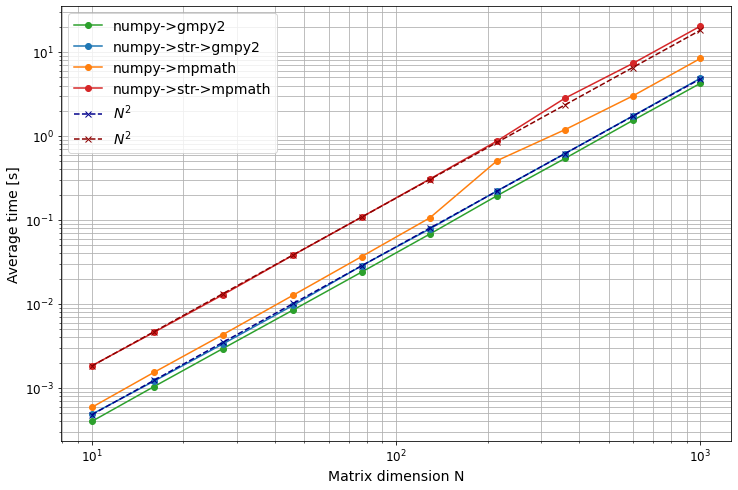

In [91]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:green", "tab:blue", "tab:orange", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/(benchmarks.n_range[-6])**2)*benchmarks.n_range**2, 'x--', color="darkblue", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[3, -6]/benchmarks.n_range[-6]**2)*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")

ax.set_xlabel("Matrix dimension N", fontsize=14)
ax.set_ylabel("Average time [s]", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

Two modes of conversions are benchmarked.
1. In the first mode (orange line), the multi-precision float is directly constructed from a Python float;
2. In the second mode (red line), the multi-precision float is constructed from a string.

For `mpmath`, it turns out that the second mode is more expensive by a factor of $2\sim 3$. Unforunately, using a string is typically the only way to go if the source has higher precisions than double precision, e.g. converting from gmpy2 floats. The overhead cost in `gmpy2` however is much lower.

### Linear algebra efficiency

The speed of linear algebra is tested with the matrix-matrix multiplication (matmul).

Result shows that `gmpy2` float can be 5~6 times more efficient than `mpmath` float.
However, since neither are as optimized as double-precision float in numpy, the matmul operation follows an uninteresting $N^3$ even at moderate dimension, and can be 4 orders of magnitudes slower than numpy.

In [48]:
rng = np.random.default_rng()

def params_setup(Nmax):
    A, B = rng.normal(size=(Nmax, Nmax)), rng.normal(size=(Nmax, Nmax))
    A_gp = np.array([[gp.mpfr(A[i_r, i_c], 112) for i_c in range(A.shape[1])] for i_r in range(A.shape[0])], dtype=object)
    B_gp = np.array([[gp.mpfr(B[i_r, i_c], 112) for i_c in range(B.shape[1])] for i_r in range(B.shape[0])], dtype=object)
    A_mp = np.array([[mp.mpf(A[i_r, i_c]) for i_c in range(A.shape[1])] for i_r in range(A.shape[0])], dtype=object)
    B_mp = np.array([[mp.mpf(B[i_r, i_c]) for i_c in range(B.shape[1])] for i_r in range(B.shape[0])], dtype=object)
    return A, B, A_gp, B_gp, A_mp, B_mp

benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda a1, b1, a2, b2, a3, b3: a1 @ b1,
        lambda a1, b1, a2, b2, a3, b3: a2 @ b2, 
        lambda a1, b1, a2, b2, a3, b3: a3 @ b3
    ],
    labels=["numpy", "gmpy2", "mpmath"],
    n_range=[int(N) for N in np.logspace(0.5, 2, num=10)],
    equality_check=None,
    show_progress=False
)

Output()

In [49]:
benchmarks

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n   ┃ numpy                  ┃ gmpy2                  ┃ mpmath                ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 3   │ 2.1000000000000002e-06 │ 1.25e-05               │ 6.440000000000001e-05 │
│ 4   │ 2.1000000000000002e-06 │ 2.82e-05               │ 0.0001564             │
│ 6   │ 2.2e-06                │ 9.38e-05               │ 0.0005498             │
│ 10  │ 2.4000000000000003e-06 │ 0.00044050000000000003 │ 0.0026460000000000003 │
│ 14  │ 3e-06                  │ 0.0012384000000000002  │ 0.0073844             │
│ 21  │ 6.200000000000001e-06  │ 0.0042145              │ 0.0255995             │
│ 31  │ 7.3e-06                │ 0.013646400000000001   │ 0.0831509             │
│ 46  │ 9.100000000000001e-06  │ 0.0449458              │ 0.27911040000000004   │
│ 68  │ 1.3100000000000002e-05 │ 0.145908               │ 0.9214535             │
│ 100 │ 2.16e-05               │ 0.46882250000000003    │ 3.0447109             │
└─────┴────────────────────────┴────────────────────────┴───────────────────────┘

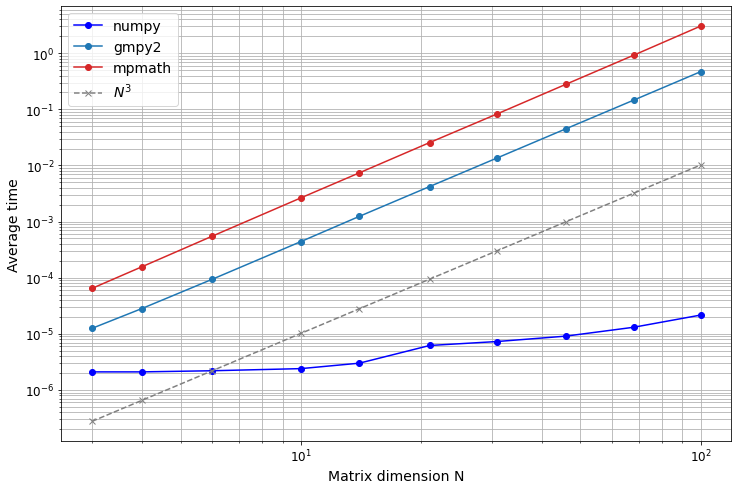

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["blue", "tab:blue", "tab:red"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -8]/(benchmarks.n_range[-8])**3)*benchmarks.n_range**3, 'x--', color="gray", label=r"$N^3$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/(benchmarks.n_range[-6])**3)*benchmarks.n_range**3, 'x--', color="darkblue", label=r"$N^2$")
# ax.loglog(benchmarks.n_range, (benchmarks.timings_s[2, -6]/benchmarks.n_range[-6]**3)*benchmarks.n_range**3, 'x--', color="darkred", label=r"$N^2$")

ax.set_xlabel("Matrix dimension N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

Linear algebra is also faster in `gmpy2` compared to `mpmath`. It is however unlikely that this will become a bottleneck.

---
## Multi-precision Jacobi nodes

In [92]:
from sympy.integrals.quadrature import gauss_jacobi
from pg_utils.numerics.special import roots_jacobi_mp
import sympy
import pandas as pd

Benchmark

The multi-precision Gauss-Jacobi quadrature weights and nodes calculation via `sympy.integrals.quadrature.gauss_jacobi` is used as a benchmark.

This method is quite slow, using around 25s for the following $N$, $\alpha$, $\beta$ configuration. The double-prec version `scipy.special.roots_jacobi` is very fast.

Note that there seems to be some caching in the Jacobi evaluation for `sympy`. The second run is often a lot faster.

In [93]:
%%time
xi_sp_mp, wt_sp_mp = gauss_jacobi(100, sympy.Rational(-1,2), sympy.S.Zero, n_digits=34)
xi_np_dp, wt_np_dp = specfun.roots_jacobi(100, -0.5, 0.)

CPU times: total: 46.1 s
Wall time: 48.1 s


The sympy routine to calculate the nodes is quite slow, and I don't want to waste 20-30s on calculating one set of nodes for N=100. For reduced system, we are looking at 5 nontrivial matrix blocks, so 100-150s will be spent on calculating the nodes and weights alone. For the full system, this would exceed 700s: more than 10 minutes spent on calculating the nodes and weights alone. This is unbearable.

Instead, since the double precision algorithm is very fast (and it is fast because the roots are obtained by solving the eigenvalue problem of a banded matrix, whose elements are related to the coefficients from the recurrence relation), I want to see if I can run a Newton-Rhapson refinement using the `scipy.specials.roots_jacobi` solutions as a starting point.

In [94]:
%%time

mp.mp.prec = 112
alpha_mp, beta_mp = mp.mpf("-0.5"), mp.mpf("0.0")

roots_result = roots_jacobi_mp(100, alpha_mp, beta_mp, n_dps=33, extra_dps=8, max_iter=10)
xi_mp_newton = roots_result.xi
wt_mp = roots_result.wt

CPU times: total: 141 ms
Wall time: 235 ms


In [95]:
roots_result

Jacobi polynomial root-finding result:
Root-finding successful.
Convergence to 33 digits after 3 iters

Quite successful really... and it takes only 0.2s.

In [96]:
df_nodes = pd.DataFrame(data={
    "scipy double": xi_np_dp, 
    "sympy dps=34": xi_sp_mp, 
    "scipy + Newton refine": to_gpmy2_f(xi_mp_newton)
})
df_nodes.iloc[:5, :].transpose().style.format("{:.32f}")

,0,1,2,3,4
scipy double,-0.99971229548776008311250507176737,-0.99848441235832563478425072389655,-0.99627662205050782073811888039927,-0.99309060159914885890231062148814,-0.98892941939967404785249982523965
sympy dps=34,-0.99971229548775997116606474817077,-0.99848441235832564272967596906802,-0.99627662205050781363500407860635,-0.99309060159914881138231096452343,-0.98892941939967396311380357456058
scipy + Newton refine,-0.99971229548775997116606474817077,-0.99848441235832564272967596906802,-0.99627662205050781363500407860635,-0.99309060159914881138231096452343,-0.98892941939967396311380357456058


In [97]:
df_weights = pd.DataFrame(data={
    "scipy double": wt_np_dp, 
    "sympy dps=34": wt_sp_mp,
    "scipy + Newton refine": to_gpmy2_f(wt_mp)
})

In [98]:
df_weights.iloc[:5, :].transpose().style.format("{:.32f}")

,0,1,2,3,4
scipy double,0.00052209963862769536661195823868,0.00121522418362476187191079102234,0.00190907696669464273936389631103,0.00260255023378054171565021412960,0.00329540246467605914271192801834
sympy dps=34,0.00052209963864736080483863273355,0.00121522418362357224038327179809,0.00190907696669735644718387511154,0.00260255023377868656888681827135,0.00329540246467667222387581809540
scipy + Newton refine,0.00052209963864736080483863273355,0.00121522418362357224038327179809,0.00190907696669735644718387511154,0.00260255023377868656888681827135,0.00329540246467667222387581809540


And the accuracy is definitely enough. Since the original error is already at the order of magnitude of $10^{-14}$, and Newton-Rhapson has a quadratic convergence rate, a very limited number of refinements is necessary to push it to very high precision. Because of this property, `scipy.special.roots_jacobi` also applies one iteration of Newton-Rhapson refinement after solving the eigenvalue problem.

---
## Multi-precision Jacobi eval

In [99]:
import gmpy2 as gp
import mpmath as mp
from pg_utils.numerics.special import eval_jacobi_recur_mp, to_numpy_f, to_mpmath_f, to_gpmy2_f

mp.mp.prec = 112
print(mp.mp)

ctx = gp.get_context()
ctx.precision = 112
print("gmpy2 context:\n  prec = {:d}".format(gp.get_context().precision))

Mpmath settings:
  mp.prec = 112               [default: 53]
  mp.dps = 33                 [default: 15]
  mp.trap_complex = False     [default: False]
gmpy2 context:
  prec = 112


### Precision test

In [100]:
n_range = np.arange(-2, 101)
alpha, beta = 1/2, -1/2
xi, wt = specfun.roots_jacobi(101, alpha, beta)
N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')
alpha_mp, beta_mp = mp.mpf("0.5"), mp.mpf("-0.5")
alpha_gp, beta_gp = gp.mpfr("0.5", 112), gp.mpfr("-0.5", 112)
X_mp = to_mpmath_f(X_mesh, dps=33)
X_gp = to_gpmy2_f(X_mesh, dps=33)

- Calculate using the double-precision library `scipy.special.eval_jacobi`
- Calculate using the multi-precision library `mpmath.jacobi` to 32 digits
- Calculate using the recurrence function `numerics.special.eval_jacobi_recur_mp` to 32 digits

In [104]:
Jacobi_val_scipy = specfun.eval_jacobi(N_mesh, alpha, beta, X_mesh)
Jacobi_val_recur_mp = eval_jacobi_recur_mp(N_mesh, alpha_mp, beta_mp, X_mp, backend="mpmath", dps=33)
Jacobi_val_recur_gp = eval_jacobi_recur_mp(N_mesh, alpha_gp, beta_gp, X_gp, backend="gmpy2", dps=33)
Jacobi_val_mp = np.array([[mp.jacobi(n, alpha_mp, beta_mp, x_mp) for x_mp in X_mp[0, :]] for n in n_range])

Compare the results

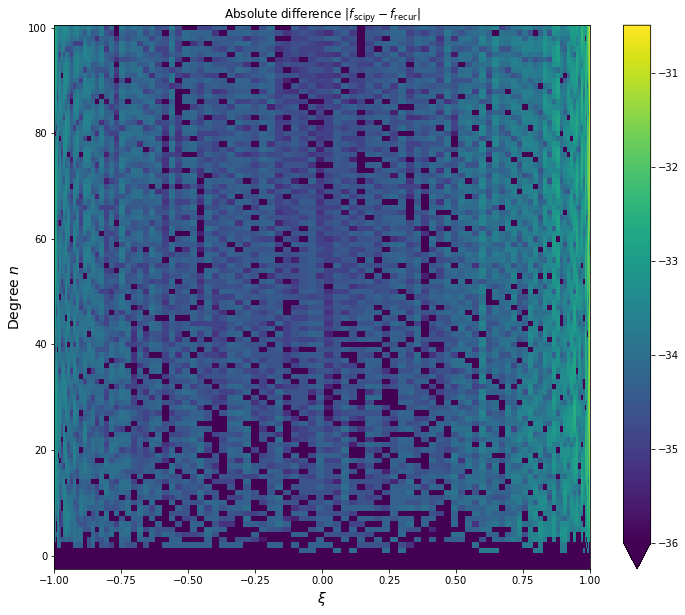

In [105]:
fig, ax = plt.subplots(figsize=(12, 10))

cmap_range = [-36, None]

# abs_err = np.abs(Jacobi_val_mp - Jacobi_val_recur_mp)
abs_err = np.abs(Jacobi_val_mp - to_mpmath_f(Jacobi_val_recur_gp, dps=33))

im = ax.pcolormesh(X_mesh, N_mesh, np.clip(np.vectorize(lambda x: float(mp.log10(x)), otypes=(np.float64,))(abs_err), *cmap_range))
ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel("Degree $n$", fontsize=14)
ax.set_title(r"Absolute difference $|f_{\mathrm{scipy}} - f_{\mathrm{recur}}|$")
plt.colorbar(im, extend="min")

plt.show()

$L_2$-error

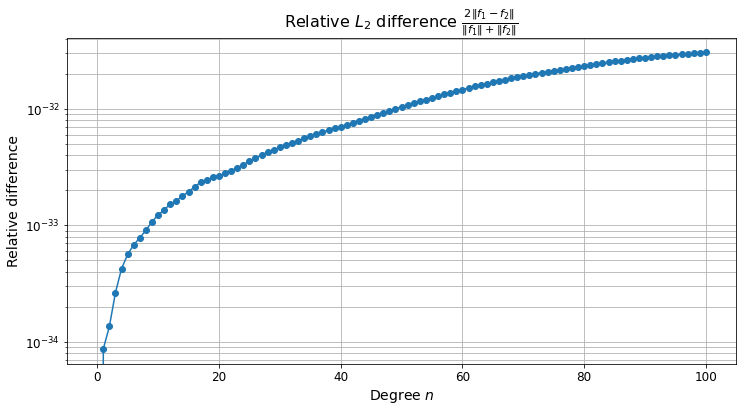

In [114]:
mp2np = np.vectorize(float, otypes=(np.float64,))

norm_Jacobi_mp = np.sum(mp2np(Jacobi_val_mp)**2*wt, axis=-1)
norm_Jacobi_recur_mp = np.sum(mp2np(Jacobi_val_recur_mp)**2*wt, axis=-1)
# norm_diff = np.sum(to_numpy_f(Jacobi_val_mp - Jacobi_val_recur_mp)**2*wt, axis=-1)
norm_diff = np.sum(to_numpy_f(Jacobi_val_mp - to_mpmath_f(Jacobi_val_recur_gp))**2*wt, axis=-1)
# norm_diff = np.sum(to_numpy_f(Jacobi_val_recur_mp - to_mpmath_f(Jacobi_val_recur_gp))**2*wt, axis=-1)

fig, ax = plt.subplots(figsize=(12, 6))

relative_err = np.sqrt(norm_diff[n_range >= 0])/((np.sqrt(norm_Jacobi_recur_mp[n_range >= 0]) + np.sqrt(norm_Jacobi_mp[n_range >= 0]))/2)
ax.semilogy(n_range[n_range >= 0], relative_err, 'o-')
ax.set_xlabel("Degree $n$", fontsize=14)
ax.set_ylabel("Relative difference", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title(r"Relative $L_2$ difference $\frac{2\Vert f_1 - f_2 \Vert}{\Vert f_1\Vert + \Vert f_2\Vert}$", fontsize=16)
ax.grid(which="both")

plt.show()

It therefore seems that what is computed using recurrence relation and what is computed using the library function is different by at most $10^{-31}$ in the relative sense.

### Efficiency test

Define functions for testing

In [115]:
from pg_utils.numerics.special import roots_jacobi_mp

npts_eval = 101
alpha, beta = 0.5, -0.5
alpha_mp, beta_mp = mp.mpf("0.5"), mp.mpf("-0.5")
alpha_gp, beta_gp = gp.mpfr("0.5"), gp.mpfr("-0.5")
xi, _ = specfun.roots_jacobi(npts_eval, alpha, beta)
xi_mp = roots_jacobi_mp(npts_eval, alpha_mp, beta_mp).xi
xi_gp = to_gpmy2_f(xi_mp, prec=112)

def params_setup(Nmax):
    n_range = np.arange(Nmax + 1)
    N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')
    _, X_mp = np.meshgrid(n_range, xi_mp, indexing='ij')
    _, X_gp = np.meshgrid(n_range, xi_gp, indexing='ij')
    return n_range, N_mesh, X_mesh, X_mp, X_gp, alpha, beta, alpha_mp, beta_mp, alpha_gp, beta_gp

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [116]:
benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda n_range, N_mesh, X_mesh, X_mp, X_gp, alpha, beta, alpha_mp, beta_mp, alpha_gp, beta_gp: specfun.eval_jacobi(N_mesh, alpha, beta, X_mesh),
        lambda n_range, N_mesh, X_mesh, X_mp, X_gp, alpha, beta, alpha_mp, beta_mp, alpha_gp, beta_gp: np.array([[mp.jacobi(n, alpha_mp, beta_mp, x_mp) for x_mp in X_mp[0, :]] for n in N_mesh[:, 0]]),
        lambda n_range, N_mesh, X_mesh, X_mp, X_gp, alpha, beta, alpha_mp, beta_mp, alpha_gp, beta_gp: eval_jacobi_recur_mp(N_mesh, alpha_mp, beta_mp, X_mp, backend="mpmath", dps=33),
        lambda n_range, N_mesh, X_mesh, X_mp, X_gp, alpha, beta, alpha_mp, beta_mp, alpha_gp, beta_gp: eval_jacobi_recur_mp(N_mesh, alpha_gp, beta_gp, X_gp, backend="gmpy2", dps=33)
    ],
    labels=["scipy", "mpmath", "mpmath-recur", "gmpy2-recur"],
    n_range=[int(10**(N/5)) for N in range(0, 16)],
    equality_check=None,
    show_progress=False
)

Output()

Compare the results

In [117]:
benchmarks

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ scipy                 ┃ mpmath              ┃ mpmath-recur          ┃ gmpy2-recur            ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1    │ 2.5e-06               │ 0.0247207           │ 0.002988              │ 0.0001228              │
│ 1    │ 2.5e-06               │ 0.0245941           │ 0.0029660000000000003 │ 0.00012240000000000002 │
│ 2    │ 4.3e-06               │ 0.0375869           │ 0.0052227             │ 0.00037880000000000005 │
│ 3    │ 6.7e-06               │ 0.050775            │ 0.007481000000000001  │ 0.0005948              │
│ 6    │ 1.79e-05              │ 0.0915049           │ 0.014687100000000002  │ 0.0012522              │
│ 10   │ 4.21e-05              │ 0.1458739           │ 0.0244941             │ 0.0021096              │
│ 15   │ 8.66e-05              │ 0.22093400000000002 │ 0.0367033             │ 0.0031795              │
│ 25   │ 0.0002442             │ 0.3662174           │ 0.062325700000000005  │ 0.005355400000000001   │
│ 39   │ 0.0006237             │ 0.5907022000000001  │ 0.09833410000000001   │ 0.0085406              │
│ 63   │ 0.0015752000000000001 │ 1.0068405           │ 0.16268210000000002   │ 0.014404900000000002   │
│ 100  │ 0.0036702             │ 1.7410241000000002  │ 0.2602144             │ 0.0251574              │
│ 158  │ 0.0084911             │ 3.116962            │ 0.4111732             │ 0.0422647              │
│ 251  │ 0.019693600000000002  │ 6.171038200000001   │ 0.9029926             │ 0.0694006              │
│ 398  │ 0.0471728             │ 12.7817059          │ 1.272744              │ 0.11531910000000001    │
│ 630  │ 0.11499000000000001   │ 27.307366000000002  │ 1.9216545             │ 0.1754187              │
│ 1000 │ 0.2853698             │ 60.502276300000005  │ 3.0884087             │ 0.2766369              │
└──────┴───────────────────────┴─────────────────────┴───────────────────────┴────────────────────────┘

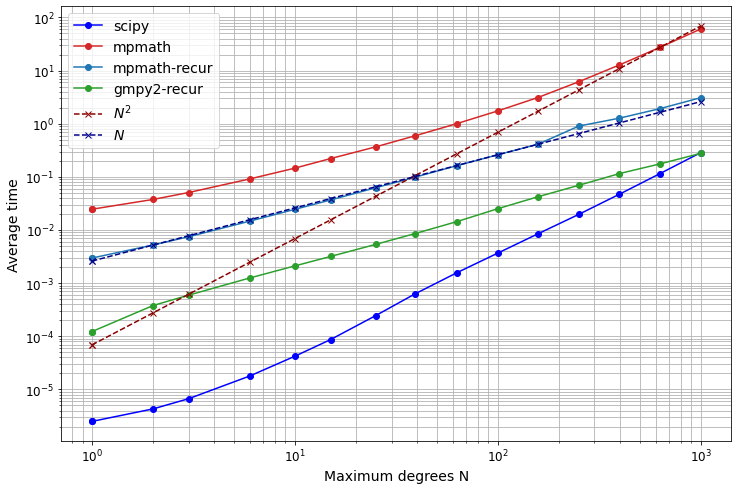

In [118]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["blue", "tab:red", "tab:blue", "tab:green"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -2]/(benchmarks.n_range[-2]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[2, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

Scalings for two approaches
- Naively calling `mpmath.jacobi` (red line) on an array of degrees up to degree N roughly gives a complexity of $O(N^2)$. However this trend only seems to be asymptotically true at quite large $N$.
- Using recurrence relations to generate values for the same array of degrees gives a complexity of $O(N)$.

Multi-precision evaluation with recurrence relation still hardly beats double-prec function `scipy.special.eval_jacobi`, at least at a reasonable degree. At the designed resolution ($N=50\sim 100$), a gap of two orders of magnitude or a little less is expected between the cost of quadruple-precision evaluation in `mpmath` with recurrence relation and the cost of double-precision evaluation. The other library, `gmpy2`, is more efficient, and reduces this gap to $\sim 10\times$ within this degree range. It starts to overtake the `scipy` built-in function at $N=1000$. The resolution of $N=1000$ is highly unlikely to be useful, otherwise we also need to extend the range drastically, in addition to the precision.

---
## Matrix calculation

In [35]:
import sympy, json
from pg_utils.pg_model import expansion as xpd
from pg_utils.numerics import matrices as nmatrix

with open("./out/eigen/Malkus/Reduced/matrix_expr.json", 'r') as f:
    matrix_obj = json.load(f)
    M_expr = xpd.SystemMatrix.deserialize(matrix_obj["M"])
    K_expr = xpd.SystemMatrix.deserialize(matrix_obj["K"])

In [36]:
from pg_utils.pg_model import params
from pg_utils.pg_model.expand_stream_force import recipe as xpd_recipe

par_val = {
    params.Le: sympy.Rational(1, 10000),
    xpd.m: 3
}

element = M_expr["Psi", "Psi"].subs(par_val)

Ntrunc = 5
ranges_trial = np.arange(Ntrunc + 1)
ranges_test = np.arange(Ntrunc + 1)

element_xpd = nmatrix.InnerQuad_GaussJacobi(element, 
    {"automatic": True, "quadN": None})

In [38]:
alpha_min, beta_min, quadN, alpha_lmin, beta_lmin = element_xpd.deduce_params_outer(Ntrunc, Ntrunc)

In [42]:
beta_min

3

In [104]:
from pg_utils.numerics.special import transform_dps_prec

In [142]:
transform_dps_prec(prec=10)

(2, 10)

In [139]:
sympy.srepr(sympy.Rational(1, 1000).evalf(20))

"Float('0.00099999999999999999999985', precision=70)"

In [176]:
mp.mp.prec = 112
print(mp.mp)

Mpmath settings:
  mp.prec = 112               [default: 53]
  mp.dps = 33                 [default: 15]
  mp.trap_complex = False     [default: False]


In [158]:
1j*mp.mpf("1.0")

mpc(real='0.0', imag='1.0')

In [249]:
gp.mpfr("0.123456789876543212345678987654321", 112)

mpfr('0.12345678987654321234567898765432099',112)

In [194]:
opd_B = element._opd_B.doit()

In [195]:
opd_B

(-9*(1/2 - \xi/2)*(\xi/2 + 1/2)*jacobi(\ell, 3/2, 3, \xi) - 9*(\xi/2 + 1/2)**2*jacobi(\ell, 3/2, 3, \xi)/2 + (\xi/2 + 1/2)*((1/2 - \xi/2)**(3/2)*(2*\ell + 11)*(\xi/2 + 1/2)*((2*\ell + 13)*(\xi/2 + 1/2)*jacobi(\ell - 2, 7/2, 5, \xi) + jacobi(\ell - 1, 5/2, 4, \xi)) + 6*(1/2 - \xi/2)**(3/2)*(2*\ell + 11)*(\xi/2 + 1/2)*jacobi(\ell - 1, 5/2, 4, \xi) + 6*(1/2 - \xi/2)**(3/2)*jacobi(\ell, 3/2, 3, \xi) - 6*sqrt(1/2 - \xi/2)*(2*\ell + 11)*(\xi/2 + 1/2)**2*jacobi(\ell - 1, 5/2, 4, \xi) - 18*sqrt(1/2 - \xi/2)*(\xi/2 + 1/2)*jacobi(\ell, 3/2, 3, \xi) + 3*(\xi/2 + 1/2)*(-sqrt(1/2 - \xi/2) + (\xi/2 + 1/2)/sqrt(1/2 - \xi/2))*jacobi(\ell, 3/2, 3, \xi))/sqrt(1/2 - \xi/2) + (4*(1/2 - \xi/2)**(3/2)*(\ell/2 + 11/4)*(\xi/2 + 1/2)**2*jacobi(\ell - 1, 5/2, 4, \xi) + 3*(1/2 - \xi/2)**(3/2)*(\xi/2 + 1/2)*jacobi(\ell, 3/2, 3, \xi) - 3*sqrt(1/2 - \xi/2)*(\xi/2 + 1/2)**2*jacobi(\ell, 3/2, 3, \xi))/sqrt(1/2 - \xi/2) + (\xi/2 + 1/2)*(4*(1/2 - \xi/2)**(3/2)*(\ell/2 + 11/4)*(\xi/2 + 1/2)**2*jacobi(\ell - 1, 5/2, 4, \

In [196]:
opd_B_func = sympy.lambdify((xpd.n_trial, xpd.xi), opd_B, modules=["mpmath"])

In [198]:
print(opd_B_func.__doc__)

Created with lambdify. Signature:

func(\ell, \xi)

Expression:

(-9*(1/2 - \xi/2)*(\xi/2 + 1/2)*jacobi(\ell, 3/2, 3, \xi) - 9*(\xi/2 +...

Source code:

def _lambdifygenerated(Dummy_90, Dummy_89):
    return (mpf(1)/mpf(4))*(-9*(mpf(1)/mpf(2) - mpf(1)/mpf(2)*Dummy_89)*((mpf(1)/mpf(2))*Dummy_89 + mpf(1)/mpf(2))*jacobi(Dummy_90, mpf(3)/mpf(2), 3, Dummy_89) - mpf(9)/mpf(2)*((mpf(1)/mpf(2))*Dummy_89 + mpf(1)/mpf(2))**2*jacobi(Dummy_90, mpf(3)/mpf(2), 3, Dummy_89) + ((mpf(1)/mpf(2))*Dummy_89 + mpf(1)/mpf(2))*((mpf(1)/mpf(2) - mpf(1)/mpf(2)*Dummy_89)**(mpf(3)/mpf(2))*((mpf(1)/mpf(2))*Dummy_89 + mpf(1)/mpf(2))*(2*Dummy_90 + 11)*(((mpf(1)/mpf(2))*Dummy_89 + mpf(1)/mpf(2))*(2*Dummy_90 + 13)*jacobi(Dummy_90 - 2, mpf(7)/mpf(2), 5, Dummy_89) + jacobi(Dummy_90 - 1, mpf(5)/mpf(2), 4, Dummy_89)) + 6*(mpf(1)/mpf(2) - mpf(1)/mpf(2)*Dummy_89)**(mpf(3)/mpf(2))*((mpf(1)/mpf(2))*Dummy_89 + mpf(1)/mpf(2))*(2*Dummy_90 + 11)*jacobi(Dummy_90 - 1, mpf(5)/mpf(2), 4, Dummy_89) + 6*(mpf(1)/mpf(2) - mpf(1)/mpf(2)*

In [202]:
my_expr = sympy.sqrt(3)*xpd.xi/10000

In [203]:
my_expr

sqrt(3)*\xi/10000

In [204]:
my_func = sympy.lambdify((xpd.xi,), my_expr, modules=["mpmath"])

In [205]:
print(my_func.__doc__)

Created with lambdify. Signature:

func(\xi)

Expression:

sqrt(3)*\xi/10000

Source code:

def _lambdifygenerated(Dummy_91):
    return (mpf(1)/mpf(10000))*sqrt(3)*Dummy_91


Imported modules:




In [224]:
my_expr.subs({xpd.xi: 1}).evalf(32)

0.00017320508075688772935274463415059

In [232]:
str(my_func(my_array))

"[mpf('0.000173205080756887729352744634150587262')\n mpf('0.000173205080756887729352744634150587262')\n mpf('0.000173205080756887729352744634150587262')\n mpf('0.000173205080756887729352744634150587262')\n mpf('0.000173205080756887729352744634150587262')\n mpf('0.000173205080756887729352744634150587262')\n mpf('0.000173205080756887729352744634150587262')\n mpf('0.000173205080756887729352744634150587262')\n mpf('0.000173205080756887729352744634150587262')\n mpf('0.000173205080756887729352744634150587262')]"

In [228]:
mp.mp.prec = 112

In [231]:
my_array = np.array([mp.mpf("1") for i in range(10)], dtype=object)
my_array

array([mpf('1.0'), mpf('1.0'), mpf('1.0'), mpf('1.0'), mpf('1.0'),
       mpf('1.0'), mpf('1.0'), mpf('1.0'), mpf('1.0'), mpf('1.0')],
      dtype=object)

---
## Velocity and vorticity basis

In [42]:
from scipy.special import binom, eval_jacobi, roots_jacobi

def basis_psi(m, n, s):
    xi = 2*s**2 - 1
    return s**m*(1 - s**2)**(3/2)*eval_jacobi(n, 3/2, m, xi)

def basis_u_s(m, n, s):
    xi = 2*s**2 - 1
    return m*s**(m-1)*(1-s**2)*eval_jacobi(n, 3/2, m, xi)

def basis_u_p(m, n, s):
    xi = 2*s**2 - 1
    return s**(m-1)*(3*s**2 - m*(1-s**2))*eval_jacobi(n, 3/2, m, xi) - s**(m + 1)*(1 - s**2)*(n + m + 5/2)*eval_jacobi(n-1, 5/2, m+1, xi)

def basis_zeta(m, n, s):
    xi = 2*s**2 - 1
    return (2*(n + 1)*(2*n + 2*m + 3) + m)*s**m*eval_jacobi(n, 3/2, m, xi)

Calculate the basis functions

In [49]:
m = 3
n_array = np.array([1, 3, 5, 10])
curve_colors = ["tab:blue", "tab:green", "tab:orange", "tab:red"]
xi_array, _ = roots_jacobi(200, 3/2, m)
s_array = np.r_[0., np.sqrt((1 + xi_array)/2), 1.]

N_mesh, S_mesh = np.meshgrid(n_array, s_array, indexing='ij')

basis_val_psi = basis_psi(m, N_mesh, S_mesh)
basis_val_u_s = basis_u_s(m, N_mesh, S_mesh)
basis_val_u_p = basis_u_p(m, N_mesh, S_mesh)
basis_val_zeta = basis_zeta(m, N_mesh, S_mesh)

Plot the basis functions

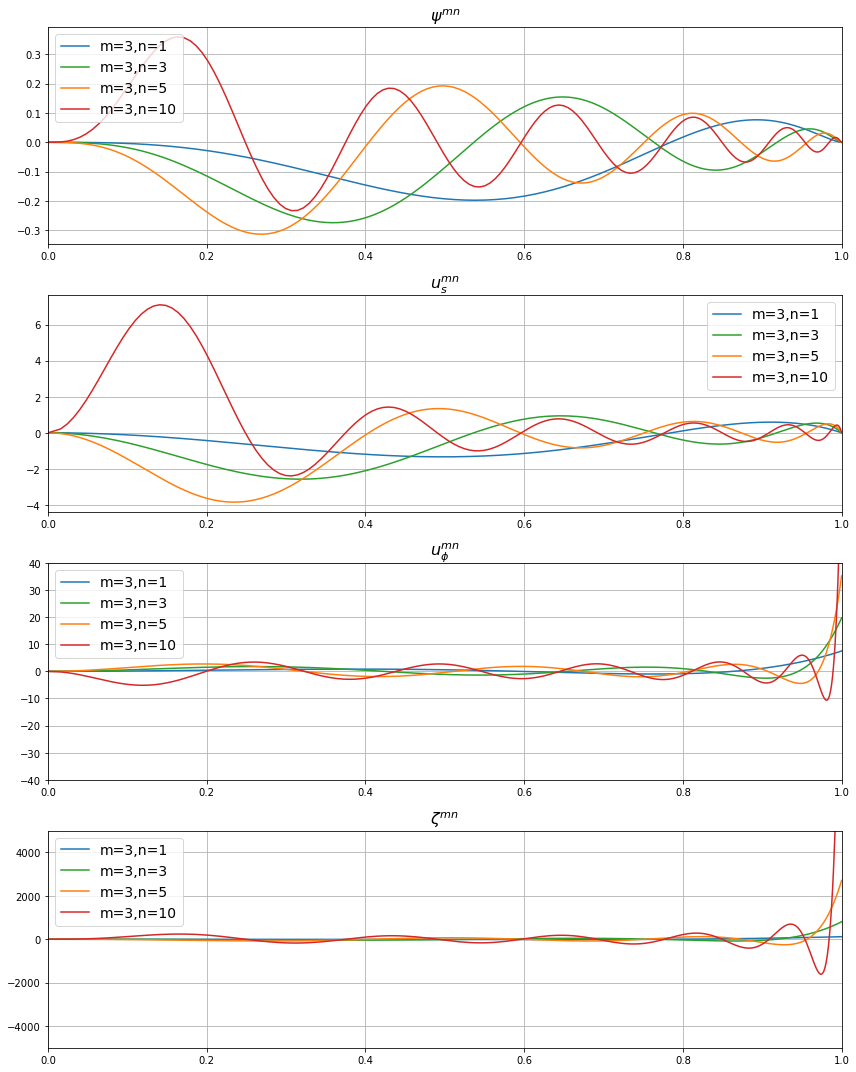

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 15))

ax = axes[0]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_psi[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$\psi^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)

ax = axes[1]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_u_s[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$u_s^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)

ax = axes[2]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_u_p[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$u_\phi^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([-40, +40])

ax = axes[3]
for i_n, n in enumerate(n_array):
    ax.plot(s_array, basis_val_zeta[i_n], color=curve_colors[i_n], label="m=%d,n=%d" % (m, n))
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_title(r"$\zeta^{mn}$", fontsize=16)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([-5000, +5000])

plt.tight_layout()
plt.savefig("./out/imgs/basis_velocity_vorticity.pdf", format="pdf", bbox_inches="tight")
plt.show()